In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import init
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
from RefModel.model_CapsNet import *

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

# Cross species : HPP

# 메모
    - GPMDP training dataset은 7.5만개의 펩타이드로 구성, 반반 레이블링
    - DeepMSPeptide, CapsNet 둘다 MOps를 0, LOps를 1로 레이블링해서 학습
    - 추론할때 확률이 높을수록 디텍터블하지 않은 것임
        - DeepMSpeptide의 경우 그래서 1-확률로 바꿔서 표현 (deepMSpeptide공식깃헙 문서에 그렇게 코딩되어있음.)
        - CapsNet도 같은 학습셋을 쓰는데 MOps에 0으로 레이블 된 것 확인함

In [4]:
gpmdb_train = pd.read_csv('RefModel/2019Bioinformatics_DeepMSPeptide/Datasets/GPMDB_training_peptides.txt', sep='\t')
d_train = gpmdb_train.loc[gpmdb_train.Class=='LObs'].Peptide_seq.unique()

In [5]:
gpmdb_train = pd.read_csv('RefModel/2021MDPI_CapsNet/data/train.csv')
c_train = gpmdb_train.loc[gpmdb_train.Label==1].Seqs.unique()

In [6]:
print(len(c_train), len(d_train), len(set(c_train).intersection(d_train)))

37500 37500 37500


In [7]:
hpp_n = pd.read_csv('RefModel/2021MDPI_CapsNet/mp.csv').Seqs.unique()

In [8]:
set(hpp_n).intersection(set(c_train))

set()

In [9]:
def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)


LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
original_train, original_val, original_test = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/data/', train='train.csv', validation='train.csv',test='test.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(original_train, original_val, original_test)

model = CapsuleNet()
"""
将前面生成的词向量矩阵拷贝到模型的embedding层
这样就自动的可以将输入的word index转为词向量
"""
# 训练
model.to(DEVICE)
# 训练
optimizer = optim.Adam(model.parameters(),lr=0.001)

n_class = 2

model.load_state_dict(torch.load('RefModel/2021MDPI_CapsNet/model/params.pkl'))#, map_location='cpu'))
model.eval()

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [10]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')[['peptide', 'Class']]

pe1 = df_hpp.loc[df_hpp['Class']=='PE1'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
dmp = df_hpp.loc[df_hpp['Class']=='Detected_MPs'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
mp = df_hpp.loc[df_hpp['Class']=='MPs'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)

pe1['Label']=1
dmp['Label']=1
mp['Label']=0

pe1.to_csv('RefModel/2021MDPI_CapsNet/pe1.csv', index=False)
dmp.to_csv('RefModel/2021MDPI_CapsNet/dmp.csv', index=False)
mp.to_csv('RefModel/2021MDPI_CapsNet/mp.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='pe1.csv',validation='pe1.csv',test='pe1.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter1 = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

train2,val2,test2 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='dmp.csv',validation='dmp.csv',test='dmp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train2,val2,test2)
test_iter2 = data.BucketIterator(val2, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

train3,val3,test3 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mp.csv',validation='mp.csv',test='mp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train3, val3,test3)
test_iter3 = data.BucketIterator(val3, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
all_pred1 = []
all_true1 = []
all_p1 = []
for batch_idx, batch in enumerate(test_iter1):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        try:
            out = model(data)
        except:
            print(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p1.extend(list(out1.cpu().detach().numpy()))
        all_pred1.extend(list(y_pre.cpu().detach().numpy()))
        all_true1.extend(list(batch.Label.cpu().detach().numpy()))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [12]:
all_pred2 = []
all_true2 = []
all_p2 = []
for batch_idx, batch in enumerate(test_iter2):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p2.extend(list(out1.cpu().detach().numpy()))
        all_pred2.extend(list(y_pre.cpu().detach().numpy()))
        all_true2.extend(list(batch.Label.cpu().detach().numpy()))

In [13]:
all_pred3 = []
all_true3 = []
all_p3 = []
for batch_idx, batch in enumerate(test_iter3):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p3.extend(list(out1.cpu().detach().numpy()))
        all_pred3.extend(list(y_pre.cpu().detach().numpy()))
        all_true3.extend(list(batch.Label.cpu().detach().numpy()))

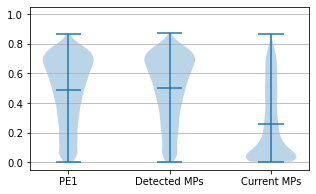

In [14]:
plt.figure(figsize=(5,3))
a = plt.violinplot([list(map(lambda x: 1-x, all_p1)), 
                    list(map(lambda x: 1-x, all_p2)), 
                    list(map(lambda x: 1-x, all_p3))],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(3)], ['PE1', 'Detected MPs', 'Current MPs'])
plt.ylim(-0.05, 1.05)
b = plt.grid(axis='y')
plt.show()

In [15]:
hpp_pred = np.array(list(map(lambda x: 1-x, np.concatenate([all_pred1, all_pred2, all_pred3]))))
hpp_true = np.concatenate([all_true1, all_true2, all_true3])
hpp_prob = np.array(list(map(lambda x: 1-x, np.concatenate([all_p1, all_p2, all_p3]))))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = metrics.accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))

TEST Accuracy : 0.6816912301808963
TEST AUC : 0.7682903116654968
              precision    recall  f1-score   support

           0     0.4439    0.7445    0.5561      6234
           1     0.8757    0.6587    0.7519     17039

    accuracy                         0.6817     23273
   macro avg     0.6598    0.7016    0.6540     23273
weighted avg     0.7600    0.6817    0.6994     23273



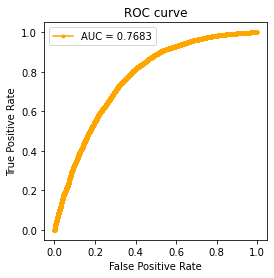

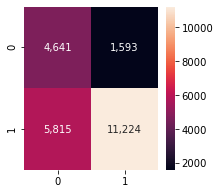

In [19]:
plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [21]:
np.save('log/result_HPP_CapsNet_fpr.npy', fpr)
np.save('log/result_HPP_CapsNet_tpr.npy', tpr)
np.save('log/result_HPP_CapsNet_threshold.npy', threshold)
np.save('log/result_HPP_CapsNet_prob.npy', hpp_prob)
np.save('log/result_HPP_CapsNet_true.npy', hpp_true)

# Cross species - Mouse

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.19988311199455844
TEST AUC : 0.8586283074447456
              precision    recall  f1-score   support

           0     0.8360    0.1950    0.3163   1436852
           1     0.0190    0.2897    0.0357     77418

    accuracy                         0.1999   1514270
   macro avg     0.4275    0.2424    0.1760   1514270
weighted avg     0.7942    0.1999    0.3019   1514270



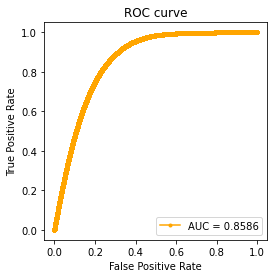

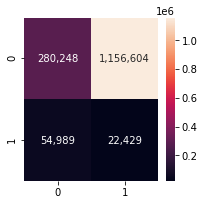

In [16]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse_KLife.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse_KLife.csv',validation='mouse_KLife.csv',test='mouse_KLife.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_KLife_CapsNet_true.npy', all_true1)

TEST Accuracy : 0.8001168880054416
TEST AUC : 0.8306138344213212
              precision    recall  f1-score   support

           0     0.9810    0.8050    0.8843   1436852
           1     0.1640    0.7103    0.2665     77418

    accuracy                         0.8001   1514270
   macro avg     0.5725    0.7576    0.5754   1514270
weighted avg     0.9392    0.8001    0.8527   1514270



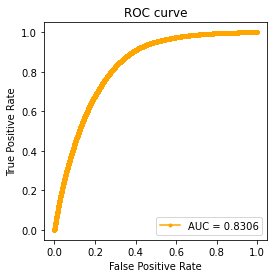

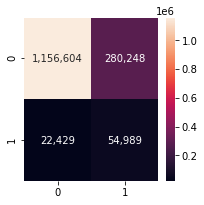

In [23]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse_KLife.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse_KLife.csv',validation='mouse_KLife.csv',test='mouse_KLife.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_KLife_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


TEST Accuracy : 0.1980638098899331
TEST AUC : 0.8584911212040486
              precision    recall  f1-score   support

           0     0.8215    0.1931    0.3127   1385973
           1     0.0201    0.2832    0.0376     81135

    accuracy                         0.1981   1467108
   macro avg     0.4208    0.2381    0.1751   1467108
weighted avg     0.7772    0.1981    0.2975   1467108



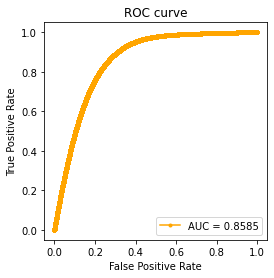

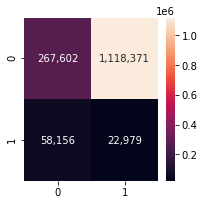

In [10]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_eph4/data.csv')[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse_KLife_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse_KLife_msgf.csv',validation='mouse_KLife_msgf.csv',test='mouse_KLife_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]  # original model : 0 is Detectable peptide
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_msgf_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_msgf_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_msgf_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_msgf_KLife_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20823990862460748
TEST AUC : 0.8255219307665278
              precision    recall  f1-score   support

           0     0.8479    0.2006    0.3244   1257928
           1     0.0234    0.3472    0.0438     69344

    accuracy                         0.2082   1327272
   macro avg     0.4356    0.2739    0.1841   1327272
weighted avg     0.8048    0.2082    0.3098   1327272



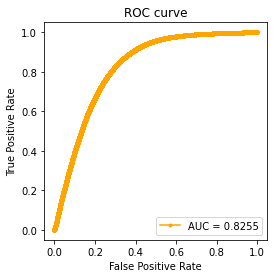

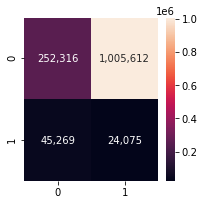

In [17]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse_SkeletaMuscle.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse_SkeletaMuscle.csv',validation='mouse_SkeletaMuscle.csv',test='mouse_SkeletaMuscle.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20765799479088703
TEST AUC : 0.8200367607467941
              precision    recall  f1-score   support

           0     0.8458    0.1997    0.3230   1265207
           1     0.0240    0.3505    0.0449     70913

    accuracy                         0.2077   1336120
   macro avg     0.4349    0.2751    0.1839   1336120
weighted avg     0.8022    0.2077    0.3083   1336120



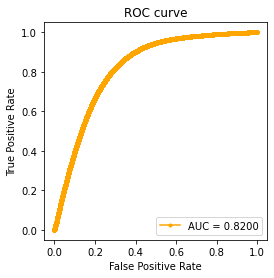

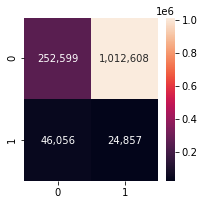

In [11]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse_SkeletaMuscle_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse_SkeletaMuscle_msgf.csv',validation='mouse_SkeletaMuscle_msgf.csv',test='mouse_SkeletaMuscle_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_SkeletaMuscle_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_msgf_SkeletaMuscle_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_msgf_SkeletaMuscle_CapsNet_true.npy', all_true1)

# Cross species - Human

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20030262643672403
TEST AUC : 0.8295545909848324
              precision    recall  f1-score   support

           0     0.8073    0.1881    0.3051   1862789
           1     0.0316    0.3715    0.0583    133071

    accuracy                         0.2003   1995860
   macro avg     0.4195    0.2798    0.1817   1995860
weighted avg     0.7556    0.2003    0.2886   1995860



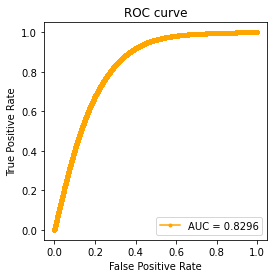

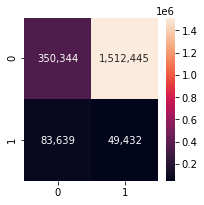

In [18]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/human_HEK293.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='human_HEK293.csv',validation='human_HEK293.csv',test='human_HEK293.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HEK293_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HEK293_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HEK293_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HEK293_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.19827694470301174
TEST AUC : 0.8315210721753766
              precision    recall  f1-score   support

           0     0.7918    0.1858    0.3010   1723461
           1     0.0328    0.3613    0.0602    131848

    accuracy                         0.1983   1855309
   macro avg     0.4123    0.2735    0.1806   1855309
weighted avg     0.7378    0.1983    0.2839   1855309



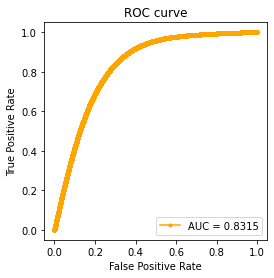

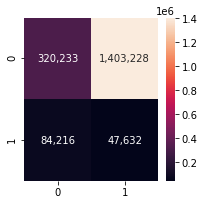

In [12]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_hek293/data.csv')[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/human_HEK293_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='human_HEK293_msgf.csv',validation='human_HEK293_msgf.csv',test='human_HEK293_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HEK293_CapsNet_fpr.npy', fpr)
np.save('log/result_human_msgf_HEK293_CapsNet_tpr.npy', tpr)
np.save('log/result_human_msgf_HEK293_CapsNet_threshold.npy', threshold)
np.save('log/result_human_msgf_HEK293_CapsNet_prob.npy', all_p1)
np.save('log/result_human_msgf_HEK293_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20991233008068516
TEST AUC : 0.8314043799883954
              precision    recall  f1-score   support

           0     0.8881    0.2047    0.3328   1441079
           1     0.0166    0.3417    0.0316     56470

    accuracy                         0.2099   1497549
   macro avg     0.4523    0.2732    0.1822   1497549
weighted avg     0.8552    0.2099    0.3214   1497549



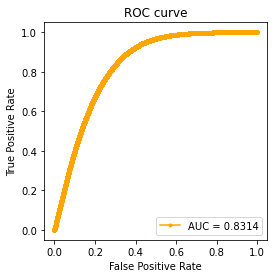

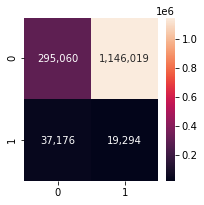

In [19]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/human_HmapLiver.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='human_HmapLiver.csv',validation='human_HmapLiver.csv',test='human_HmapLiver.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HmapLiver_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20643506692377978
TEST AUC : 0.8424199300091921
              precision    recall  f1-score   support

           0     0.8602    0.2013    0.3263   1125108
           1     0.0184    0.3137    0.0347     53621

    accuracy                         0.2064   1178729
   macro avg     0.4393    0.2575    0.1805   1178729
weighted avg     0.8219    0.2064    0.3130   1178729



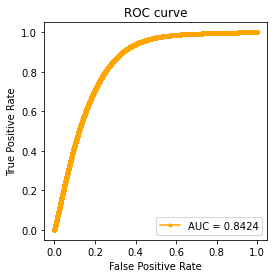

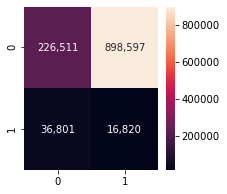

In [13]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_liver/data.csv')[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/human_HmapLiver_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='human_HmapLiver_msgf.csv',validation='human_HmapLiver_msgf.csv',test='human_HmapLiver_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HmapLiver_CapsNet_fpr.npy', fpr)
np.save('log/result_human_msgf_HmapLiver_CapsNet_tpr.npy', tpr)
np.save('log/result_human_msgf_HmapLiver_CapsNet_threshold.npy', threshold)
np.save('log/result_human_msgf_HmapLiver_CapsNet_prob.npy', all_p1)
np.save('log/result_human_msgf_HmapLiver_CapsNet_true.npy', all_true1)

# Cross species - Yeast

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.20954667781088218
TEST AUC : 0.7973550979825372
              precision    recall  f1-score   support

           0     0.8376    0.1977    0.3198    521986
           1     0.0304    0.3966    0.0565     33160

    accuracy                         0.2095    555146
   macro avg     0.4340    0.2971    0.1882    555146
weighted avg     0.7894    0.2095    0.3041    555146



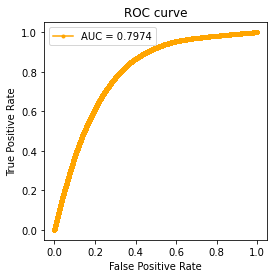

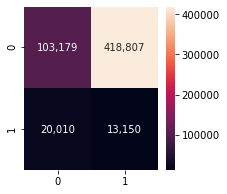

In [20]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/yeast_DelPBP1.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='yeast_DelPBP1.csv',validation='yeast_DelPBP1.csv',test='yeast_DelPBP1.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_DelPBP1_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.21237914039959271
TEST AUC : 0.7710361344149386
              precision    recall  f1-score   support

           0     0.8502    0.1992    0.3228    556165
           1     0.0317    0.4275    0.0590     34086

    accuracy                         0.2124    590251
   macro avg     0.4410    0.3133    0.1909    590251
weighted avg     0.8030    0.2124    0.3075    590251



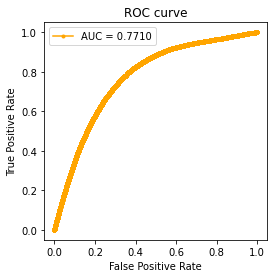

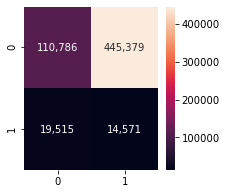

In [14]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_25/data.csv')[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/yeast_DelPBP1_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='yeast_DelPBP1_msgf.csv',validation='yeast_DelPBP1_msgf.csv',test='yeast_DelPBP1_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_DelPBP1_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_msgf_DelPBP1_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_msgf_DelPBP1_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_msgf_DelPBP1_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_msgf_DelPBP1_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.1841255141145692
TEST AUC : 0.8613323969183799
              precision    recall  f1-score   support

           0     0.6405    0.1602    0.2563    562874
           1     0.0558    0.3555    0.0964     78520

    accuracy                         0.1841    641394
   macro avg     0.3481    0.2578    0.1764    641394
weighted avg     0.5690    0.1841    0.2368    641394



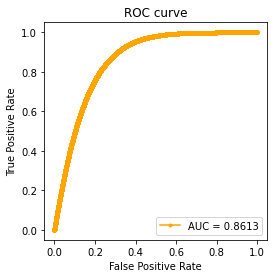

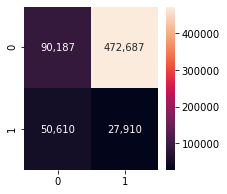

In [21]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/yeast_KLife.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='yeast_KLife.csv',validation='yeast_KLife.csv',test='yeast_KLife.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_KLife_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.18183517245138733
TEST AUC : 0.8610266751741528
              precision    recall  f1-score   support

           0     0.6175    0.1558    0.2488    558429
           1     0.0593    0.3556    0.1017     83636

    accuracy                         0.1818    642065
   macro avg     0.3384    0.2557    0.1753    642065
weighted avg     0.5448    0.1818    0.2297    642065



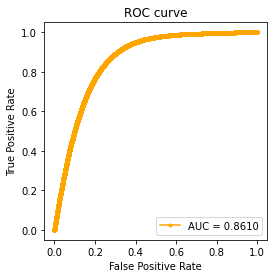

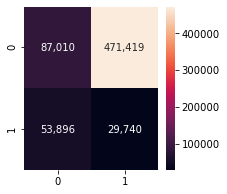

In [15]:
from torchtext import data, datasets

tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_23/data.csv')[['peptide', 'label']]#.drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/yeast_KLife_msgf.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='yeast_KLife_msgf.csv',validation='yeast_KLife_msgf.csv',test='yeast_KLife_msgf.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 0]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_msgf_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_msgf_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_msgf_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_msgf_KLife_CapsNet_true.npy', all_true1)

# massIVE-KB

In [29]:
from torchtext import data, datasets

test = pd.read_csv('RefModel/2021MDPI_CapsNet/test.csv')

In [30]:
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
train, val, test = data.TabularDataset.splits(
                                path='RefModel/2021MDPI_CapsNet/', 
                                train='train.csv',
                                validation='val.csv',
                                test='test.csv',
                                format='csv',
                                skip_header=True,
                                fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(train, val, test)
n_class = 2

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

In [31]:
model_retrained = CapsuleNet()
model_retrained.to(DEVICE)
optimizer = optim.Adam(model_retrained.parameters(),lr=0.001)
model_retrained.load_state_dict(torch.load('log/model_CapsNet.pkl'))
model_retrained.eval()

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [32]:
test_iter = data.BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=False,device=DEVICE)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [33]:
all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model_retrained(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [37]:
out

tensor([[0.3930, 0.7980],
        [0.9136, 0.1097],
        [0.7367, 0.5076],
        [0.9056, 0.2193],
        [0.9568, 0.1130],
        [0.4598, 0.6977],
        [0.9026, 0.1739],
        [0.3599, 0.7787],
        [0.9153, 0.2076],
        [0.4614, 0.7348],
        [0.6646, 0.5803],
        [0.8807, 0.2024],
        [0.9819, 0.0596],
        [0.9545, 0.0687],
        [0.9457, 0.0465],
        [0.8315, 0.4037],
        [0.9132, 0.1094],
        [0.9417, 0.0713]], device='cuda:0', grad_fn=<SqrtBackward>)

In [40]:
torch.max(out, -1)[1]

tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

TEST Accuracy : 0.82650287629023
TEST AUC : 0.9054324923265014
              precision    recall  f1-score   support

           0     0.8351    0.8193    0.8272     86495
           1     0.8180    0.8339    0.8258     84211

    accuracy                         0.8265    170706
   macro avg     0.8266    0.8266    0.8265    170706
weighted avg     0.8267    0.8265    0.8265    170706



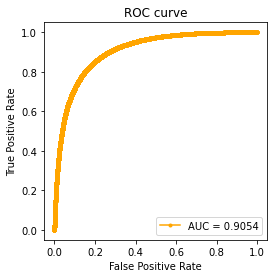

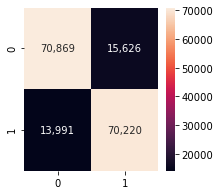

In [34]:
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [17]:
np.save('log/result_CapsNet_fpr.npy', fpr)
np.save('log/result_CapsNet_tpr.npy', tpr)

In [35]:
np.save('log/result_massivekb_ypred_capsnet.npy', np.array(all_pred1))
np.save('log/result_massivekb_yprob_capsnet.npy', np.array(all_p1))
np.save('log/result_massivekb_ytrue_capsnet.npy', np.array(all_true1))

# Case of cleavage sites count

In [18]:
probs = np.array(all_p1)
y_test = np.array(all_true1)
y_pred = np.array(all_pred1)

In [21]:
miss0_idx = np.load('RefModel/2021MDPI_CapsNet/CapsNet_miss0_idx.npy')
miss1_idx = np.load('RefModel/2021MDPI_CapsNet/CapsNet_miss1_idx.npy')
miss2_idx = np.load('RefModel/2021MDPI_CapsNet/CapsNet_miss2_idx.npy')

Test AUC : 0.8691868599385262
              precision    recall  f1-score   support

           0     0.8273    0.5418    0.6547     10970
           1     0.8852    0.9690    0.9252     40007

    accuracy                         0.8770     50977
   macro avg     0.8562    0.7554    0.7900     50977
weighted avg     0.8727    0.8770    0.8670     50977



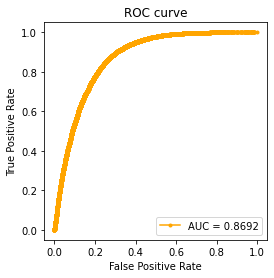

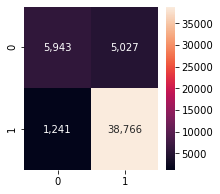

Test AUC : 0.8498007756244284
              precision    recall  f1-score   support

           0     0.7714    0.7450    0.7580     31745
           1     0.7641    0.7891    0.7764     33229

    accuracy                         0.7675     64974
   macro avg     0.7677    0.7670    0.7672     64974
weighted avg     0.7677    0.7675    0.7674     64974



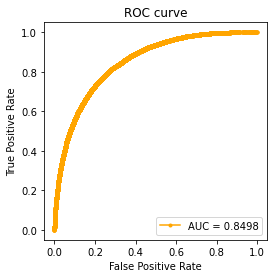

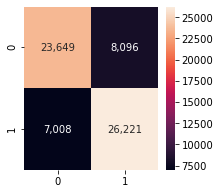

Test AUC : 0.8630282995012336
              precision    recall  f1-score   support

           0     0.8779    0.9428    0.9092     43780
           1     0.6764    0.4768    0.5594     10975

    accuracy                         0.8494     54755
   macro avg     0.7772    0.7098    0.7343     54755
weighted avg     0.8375    0.8494    0.8391     54755



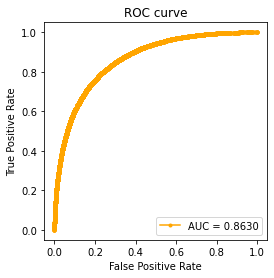

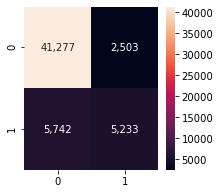

In [22]:
y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
y_test_miss0 = y_test[miss0_idx]
y_test_miss1 = y_test[miss1_idx]
y_test_miss2 = y_test[miss2_idx]

auc = roc_auc_score(y_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()



# Cross species - Mouse

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.6813797315214943
TEST AUC : 0.8942877602685556
              precision    recall  f1-score   support

           0     0.9933    0.6619    0.7944   1602113
           1     0.1730    0.9408    0.2923    120483

    accuracy                         0.6814   1722596
   macro avg     0.5832    0.8013    0.5434   1722596
weighted avg     0.9359    0.6814    0.7593   1722596



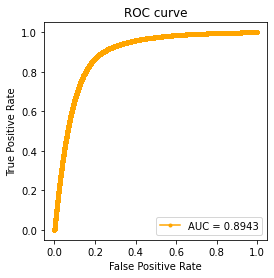

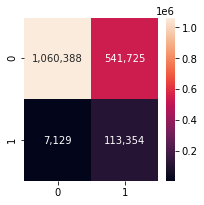

In [70]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])

tmp.to_csv('RefModel/2021MDPI_CapsNet/mouse.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='RefModel/2021MDPI_CapsNet/', train='mouse.csv',validation='mouse.csv',test='mouse.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model_retrained(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()